In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from glob import glob
from skimage.io import imread
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')

In [2]:
root_folder = '.'
data_folder = os.path.join(root_folder, 'dataset')
csv_path = os.path.join(data_folder, 'HAM10000_metadata.csv')

In [3]:
data_df = pd.read_csv(csv_path)

In [4]:
dx_dict = {
    'nv': 'Melanocytic nevus',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesion',
    'df': 'Dermatofibroma'
}

In [5]:
data_df['diagnosis'] = data_df['dx'].map(dx_dict.get)

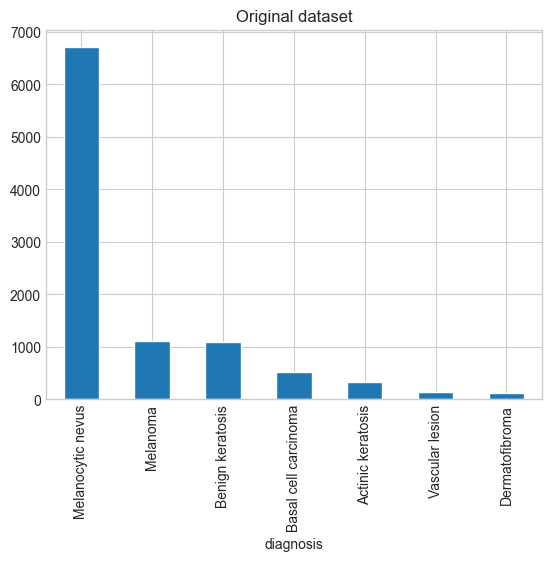

In [6]:
data_df['diagnosis'].value_counts().plot(kind='bar')
plt.title("Original dataset")
plt.show()

In [9]:
folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
augmented_data_folder = os.path.join(data_folder, 'Augmented_images')

if not os.path.exists(augmented_data_folder):
    os.mkdir(augmented_data_folder)

In [10]:
class_counts = data_df['dx'].value_counts()
class_counts

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [11]:
jpg_files = []
for folder in folders:
    jpg_files.extend(glob(os.path.join(data_folder, folder, '*.jpg')))

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in jpg_files}

data_df['path'] = data_df['image_id'].map(imageid_path_dict.get)

In [12]:
def get_data_generator():
    return tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           brightness_range=(0.8, 1.5),
                                                           shear_range=0.1,
                                                           zoom_range=0.1,
                                                           fill_mode='nearest',
                                                           horizontal_flip=True,
                                                           vertical_flip=True,
                                                           dtype=np.float32)

Found 1 validated image filenames.


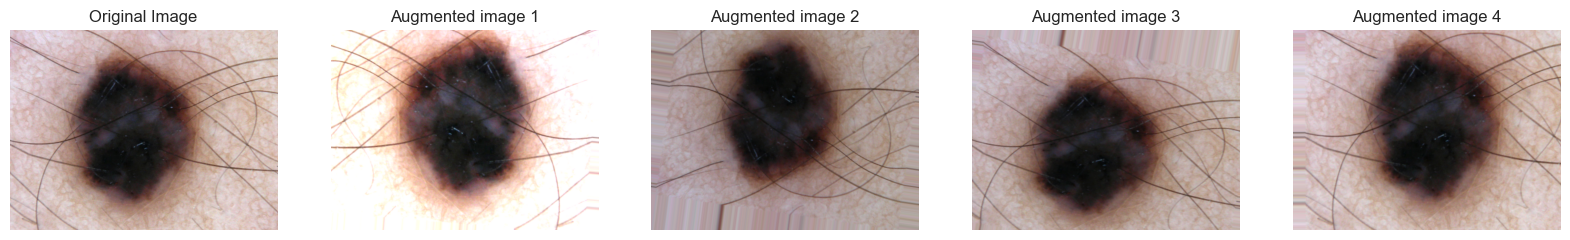

In [13]:
subset = data_df.sample(n=1)
image = imread(subset.iloc[0]["path"])
img_size = image.shape[:2]

data_gen = get_data_generator()
aug_gen = data_gen.flow_from_dataframe(subset, x_col='path', y_col=None, target_size=img_size,
                                        class_mode=None, batch_size=1, shuffle=False, 
                                        save_to_dir=None, save_prefix=None, color_mode='rgb',
                                        save_format='jpg')

n_augmentations = 4
fig, axes = plt.subplots(1, 5, figsize=(4*5, 3))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

for i in range(n_augmentations):
    img = next(aug_gen)[0]
    img = np.clip(img, 0, 255).astype(np.uint8)
    axes[i+1].imshow(img)
    axes[i+1].set_title(f'Augmented image {i+1}')
    axes[i+1].axis('off')

In [14]:
augmented_df = pd.DataFrame(columns=data_df.columns)
count = 1400
data_gen = get_data_generator()

for label in class_counts.index:
    class_subset = data_df[data_df['dx'] == label]
    if len(class_subset) < count:          
        n_augmentations = count - len(class_subset)
        aug_gen = data_gen.flow_from_dataframe(class_subset, x_col='path', y_col=None, target_size=img_size,
                                        class_mode=None, batch_size=1, shuffle=False, 
                                        save_to_dir=None, save_prefix=None, color_mode='rgb',
                                        save_format='jpg')
        new_data = []
        generated_images = 0
        iteration = 0

        while generated_images < n_augmentations:
            for i in range(len(aug_gen)):
                if generated_images >= n_augmentations:
                    break
                img = next(aug_gen)[0]  
                original_row = class_subset.iloc[aug_gen.index_array[i]]  
                new_file_name = f"{original_row['image_id']}_aug_{i}_{iteration}"
                new_path = os.path.join(augmented_data_folder, f"{new_file_name}.jpg") 
             
                tf.keras.preprocessing.image.save_img(new_path, img)

                new_row = original_row.copy()
                new_row['path'] = new_path
                new_row['image_id'] = new_file_name
                new_data.append(new_row)

                generated_images += 1

            iteration += 1

        new_df = pd.DataFrame(new_data)
        augmented_df = pd.concat([new_df, augmented_df], ignore_index=True)
    else:
        n_deletions = len(class_subset) - count
        rows_to_remove = class_subset.sample(n=n_deletions, random_state=42)
        data_df = data_df.drop(rows_to_remove.index)

Found 1113 validated image filenames.
Found 1099 validated image filenames.
Found 514 validated image filenames.
Found 327 validated image filenames.
Found 142 validated image filenames.
Found 115 validated image filenames.


In [15]:
balanced_train_val = pd.concat([augmented_df, data_df], ignore_index=True)
class_counts = balanced_train_val['dx'].value_counts()
class_counts

dx
df       1400
vasc     1400
akiec    1400
bcc      1400
bkl      1400
mel      1400
nv       1400
Name: count, dtype: int64

In [16]:
balanced_train_val.drop(["path"], axis=1, inplace=True)

In [ ]:
balanced_train_csv_path = os.path.join(data_folder, 'train.csv')
balanced_val_csv_path = os.path.join(data_folder, 'val.csv')

In [18]:
balanced_train, balanced_val = train_test_split(balanced_train_val, test_size=0.2, stratify=balanced_train_val["dx"], random_state=42)

In [19]:
print(f"Original: {len(balanced_train_val)}")
print(f"Train: {len(balanced_train)}")
print(f"Val: {len(balanced_val)}")

Original: 9800
Train: 7840
Val: 1960


In [20]:
balanced_train_val['diagnosis'] = balanced_train_val['dx'].map(dx_dict.get)
balanced_train['diagnosis'] = balanced_train['dx'].map(dx_dict.get)
balanced_val['diagnosis'] = balanced_val['dx'].map(dx_dict.get)

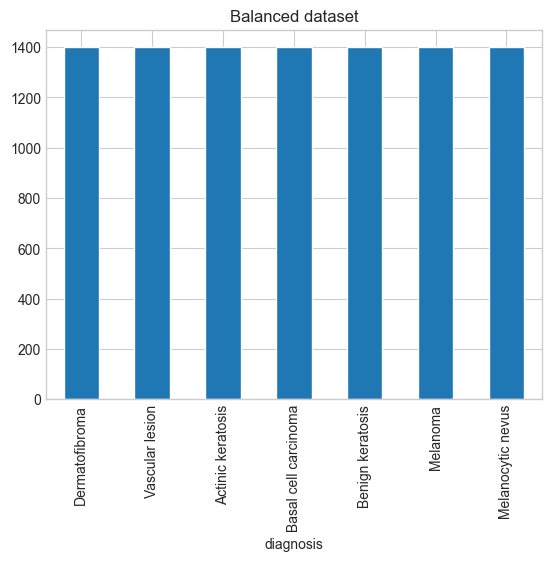

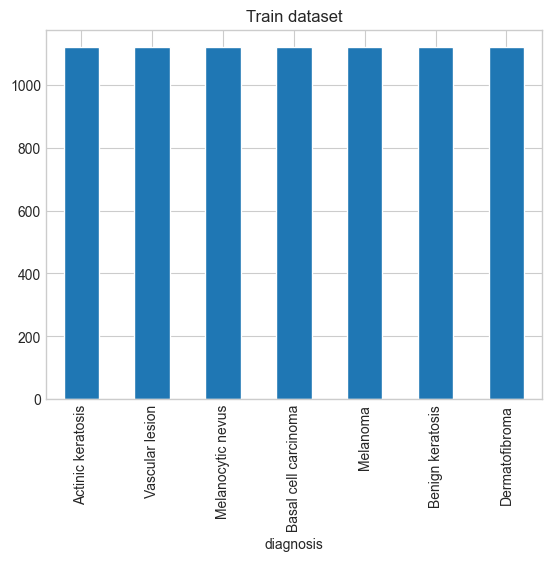

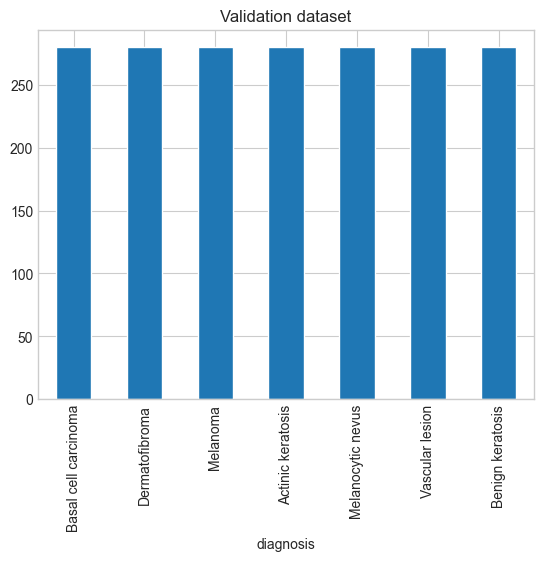

In [21]:
balanced_train_val['diagnosis'].value_counts().plot(kind='bar')
plt.title("Balanced dataset")
plt.show()

balanced_train['diagnosis'].value_counts().plot(kind='bar')
plt.title("Train dataset")
plt.show()

balanced_val['diagnosis'].value_counts().plot(kind='bar')
plt.title("Validation dataset")
plt.show()

In [22]:
balanced_train.to_csv(balanced_train_csv_path, index=False)
balanced_val.to_csv(balanced_val_csv_path, index=False)

### Test dataset

In [23]:
root_folder = '.'
data_folder = os.path.join(root_folder, 'dataset')
test_csv_path = os.path.join(data_folder, 'test_orig.csv')
new_test_csv_path = os.path.join(data_folder, 'test.csv')

In [24]:
test_df = pd.read_csv(test_csv_path)

In [25]:
test_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0034524,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0034525,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0034526,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_0034527,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0034528,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
test_df = test_df.rename(columns={'image': 'image_id'})
test_df.columns = [col.lower() if col != 'image_id' else col for col in test_df.columns]
test_df['dx'] = test_df[['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']].idxmax(axis=1)
test_df = test_df[['image_id', 'dx']]

In [27]:
test_df.head()

,image_id,dx
0,ISIC_0034524,nv
1,ISIC_0034525,nv
2,ISIC_0034526,bkl
3,ISIC_0034527,nv
4,ISIC_0034528,nv


In [28]:
test_df.to_csv(new_test_csv_path, index=False)

In [29]:
test_df['diagnosis'] = test_df['dx'].map(dx_dict.get)

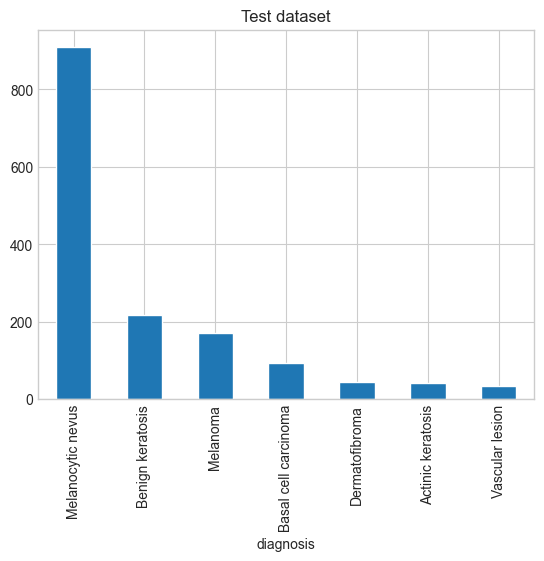

In [30]:
test_df['diagnosis'].value_counts().plot(kind='bar')
plt.title("Test dataset")
plt.show()